In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
import psutil
from torch.optim import lr_scheduler
import math
import torch.nn.functional as F

In [2]:
time = np.arange(0,1002,0.1)
#sin  = np.sin(time)*0.6
#sin  = (np.sin(time) + np.sin(2*time))*0.6/2
sin  = (np.sin(time) + np.sin(2*time))*0.6/2 + np.random.rand(len(time))*0.2
#sin  = (np.sin(time) - np.sin(2*time) + np.sin(3*time))*0.6/3 + np.random.rand(len(time))*0.2
fut_5  = sin[5:]
fut_10 = sin[10:]
fut_15 = sin[15:]
fut_20 = sin[20:]

In [17]:
df = pd.DataFrame(
    data = sin[:10000],
    index= time[:10000],
    columns = ["data"]
)
df["Future_5"]  = fut_5[:10000]
df["Future_10"] = fut_10[:10000]
df["Future_15"] = fut_15[:10000]
df["Future_20"] = fut_20[:10000]

df["history_5"] = pd.Series(df["data"].rolling(window=5)).values
df["history_10"] = pd.Series(df["data"].rolling(window=10)).values

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
df["Future_5"] = pd.Series(df['data'].rolling(window=indexer)).values

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=10)
df["Future_10"] = pd.Series(df['data'].rolling(window=indexer)).values

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=15)
df["Future_15"] = pd.Series(df['data'].rolling(window=indexer)).values

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=20)
df["Future_20"] = pd.Series(df['data'].rolling(window=indexer)).values

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
        data_df
    ):
        self.list_IDs   = list_IDs
        self.cache      = {}
        self.data_df    = data_df
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torch.tensor(self.data_df.loc[ID]["history_10"].values, dtype=torch.float32)
            #X = torch.tensor(self.data_df.loc[ID]["history_10"].values, dtype=torch.float32)
            Y = torch.tensor(self.data_df.loc[ID]["Future_10"].values, dtype=torch.float32)
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X': X,
                    'Y': Y
                }
                self.cache[ID] = data
        return X,Y
data = df[10:]
ids = data.index.values
train_ids = ids[:8000]
test_ids  = ids[8000:]

params = {
    'batch_size' : 32,
    'shuffle'    : True,
    'num_workers': 2
}

In [24]:
training_set         = Dataset( train_ids, data )
training_generator   = torch.utils.data.DataLoader( training_set, **params, pin_memory=True ) 
validation_set       = Dataset( test_ids, data )
validation_generator = torch.utils.data.DataLoader( validation_set, **params, pin_memory=True )

In [25]:
device = torch.device("cuda")

In [26]:
for batch in training_generator:
    break

## Model

In [29]:
### DEEP MANY TO MANY RNN
class rnn_deep_many_to_many(nn.Module):
    def __init__(
        self,
        dropout: float = 0.2,
        input_sequence_len   : int  = 5*24,
        input_features       : int  = 5,
        output_sequence_len  : int  = 1*24,
        output_features      : int  = 1,
        hidden_size          : int  = 2,
        hidden_layers        : int  = 2,
        activation_function  : int  = 'sigmoid',
        bidirectional        : bool = False,
    ) -> None:
        super( rnn_deep_many_to_many, self ).__init__()
        '''
        Some references:
         - https://arxiv.org/pdf/2203.09170.pdf
         - https://arxiv.org/pdf/1909.00590.pdf
        '''
        self.input_seq_len   = input_sequence_len
        self.input_features  = input_features
        self.output_seq_len  = output_sequence_len
        self.output_features = output_features
        self.bidirectional   = bidirectional
        
        self.input_size      = 2*self.input_features
        self.hidden_size     = hidden_size
        self.num_layers      = hidden_layers
        
        self.rnn_sequence_length = self.input_seq_len
        
#        self.reccurrent_layer = []
#         for i in range(self.rnn_sequence_length):
#             self.reccurrent_layer.append(
#                 nn.RNN(
#                     input_size    = self.input_size,
#                     hidden_size   = self.hidden_size,
#                     num_layers    = self.num_layers,
#                     batch_first   = True,
#                     bidirectional = self.bidirectional
#                 )
#             )

        self.reccurrent_layer = nn.ModuleList(
            nn.RNN(
                input_size    = self.input_size,
                hidden_size   = self.hidden_size,
                num_layers    = self.num_layers,
                batch_first   = True,
                bidirectional = self.bidirectional
            ) for i in range(self.rnn_sequence_length)
        )
        
        activation_functions = {
            'relu'    : nn.ReLU(), 
            'tanh'    : nn.Tanh(),
            'sigmoid' : nn.Sigmoid(),
        }
        
        self.activation_function = activation_functions[activation_function]
        
        self.fc_pre  = nn.Linear( self.input_features, self.input_size )
        
        self.fc_post = nn.Linear( self.hidden_size,   self.output_features)
        
        
    def forward(self, x):
        
        batch_size, sequence_length, features = x.shape
        x = x.reshape(-1, features)
        x = self.fc_pre(x)
        x = self.activation_function(x)
        x = x.reshape(batch_size, sequence_length, self.input_size)
        
        outputs = []
        self.hn      = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        hn = self.hn
        
        #self.reccurrent_layer.to(x.device)
        
        for i in range(self.rnn_sequence_length):
            temp, hn = self.reccurrent_layer[i](x[:,i,:].unsqueeze(1),hn)#.to(x.device)
            outputs.append(temp)

        x = torch.cat(outputs, axis=1)
        x = x.reshape(-1, self.hidden_size)
        x = self.fc_post(x)
        x = x.reshape(batch_size, self.rnn_sequence_length, self.output_features)
        x = self.activation_function(x)
        
        return x

In [31]:
'''
######### MODEL DEFAULT PARAMS #############
dropout: float = 0.2,
input_sequence_len   : int  = 5*24,
input_features       : int  = 5,
output_sequence_len  : int  = 1*24,
output_features      : int  = 1,
hidden_size          : int  = 2,
hidden_layers        : int  = 2,
activation_function  : int  = 'sigmoid',
bidirectional        : bool = False,
'''

model = rnn_deep_many_to_many(
            input_sequence_len  = 10,
            input_features      =  1,
            output_sequence_len = 10,
            output_features     =  1,
            hidden_layers       = 2,
            activation_function = 'sigmoid',
        ).to(device)

In [46]:
def train_one_epoch(model, loss_fn):
    model.train()
    running_loss = 0.
    for i,batch in enumerate(training_generator):
        X = batch[0].unsqueeze(2).to(device)
        Y = batch[1].unsqueeze(2).to(device)
        optimizer.zero_grad()
        output  = model(X)
        loss    = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        running_loss += loss
    return running_loss/(i+1)

def val_one_epoch(model, loss_fn):
    model.eval()
    running_loss = 0.
    for i,batch in enumerate(training_generator):
        X = batch[0].unsqueeze(2).to(device)
        Y = batch[1].unsqueeze(2).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output  = model(X)
        loss    = loss_fn(output, Y)
        running_loss += loss
    return running_loss/(i+1)

def train(model, epochs=10):
    loss_fn = torch.nn.L1Loss()
    train_loss = []
    val_loss   = []
    
    for epoch in range(epochs):
        model.train(True)
        print("EPOCHS: ", epoch + 1)
        loss = train_one_epoch(model, loss_fn=loss_fn)
        print("train loss: ",loss)
        train_loss.append(loss)
        model.train(False)
        loss = val_one_epoch(model, loss_fn=loss_fn)
        val_loss.append(loss)
        print("val loss: ",loss)
        scheduler.step()
    return [train_loss, val_loss]

EPOCHS:  1
train loss:  tensor(0.2652, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2466, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2467, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2465, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2465, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2467, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2464, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2467, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2464, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2466, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2464, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2465, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2463, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2464, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2463, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2464, device='cuda:0')
EPOCHS:  9
train

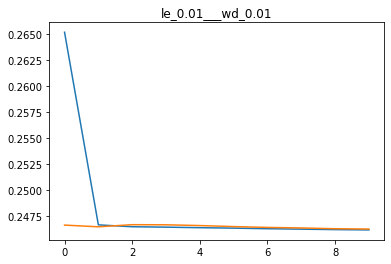

EPOCHS:  1
train loss:  tensor(0.2594, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2434, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2431, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2433, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2430, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2433, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2430, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2433, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2433, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2433, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2433, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2432, device='cuda:0')
EPOCHS:  9
train

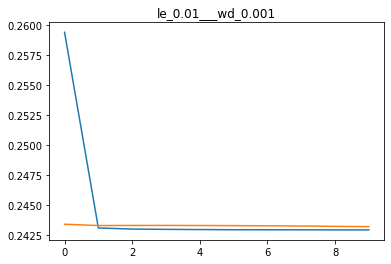

EPOCHS:  1
train loss:  tensor(0.2567, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  9
train

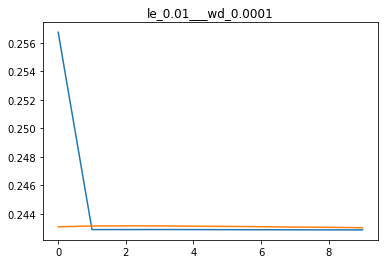

EPOCHS:  1
train loss:  tensor(0.2566, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2430, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2426, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2424, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2399, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2227, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2043, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1967, device='cuda:0')
EPOCHS:  9
train

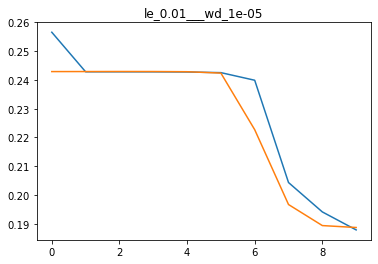

EPOCHS:  1
train loss:  tensor(0.2798, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2430, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2428, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2429, device='cuda:0')
EPOCHS:  9
train

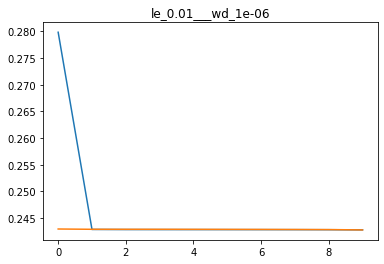

EPOCHS:  1
train loss:  tensor(0.4111, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3461, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3053, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2784, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2691, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2626, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2593, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2566, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2549, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2535, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2526, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2517, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2511, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2506, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2501, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2497, device='cuda:0')
EPOCHS:  9
train

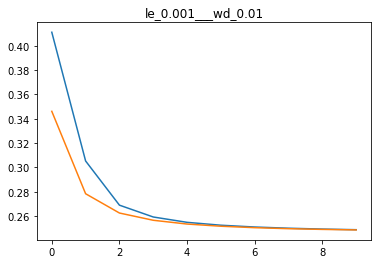

EPOCHS:  1
train loss:  tensor(0.4382, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3660, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3201, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2833, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2683, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2586, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2543, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2511, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2493, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2479, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2470, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2462, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2457, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2453, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2449, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2447, device='cuda:0')
EPOCHS:  9
train

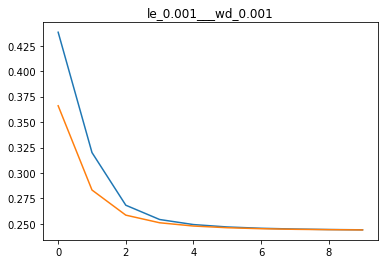

EPOCHS:  1
train loss:  tensor(0.4640, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3956, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3393, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2921, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2734, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2613, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2559, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2518, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2496, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2478, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2467, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2458, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2451, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2446, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2443, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2440, device='cuda:0')
EPOCHS:  9
train

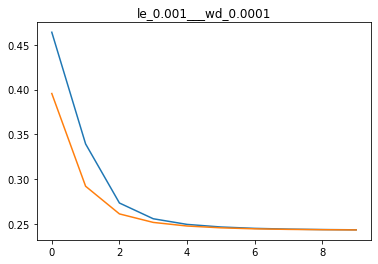

EPOCHS:  1
train loss:  tensor(0.4207, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3366, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2956, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2701, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2608, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2542, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2509, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2484, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2470, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2458, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2451, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2445, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2442, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2439, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2437, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2435, device='cuda:0')
EPOCHS:  9
train

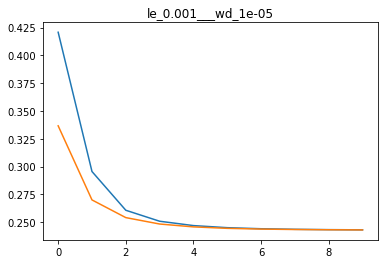

EPOCHS:  1
train loss:  tensor(0.3671, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2983, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2689, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2538, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2495, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2466, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2454, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2444, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2440, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2436, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2434, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2432, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2431, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2430, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2430, device='cuda:0')
EPOCHS:  9
train

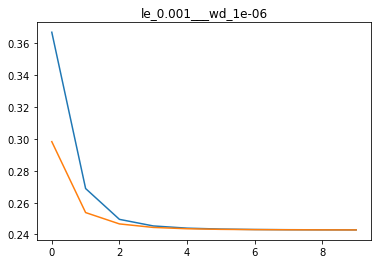

EPOCHS:  1
train loss:  tensor(0.3475, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3431, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3394, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3358, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3327, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3296, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3269, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3242, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3217, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3193, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3171, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3150, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3130, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3111, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.3094, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3076, device='cuda:0')
EPOCHS:  9
train

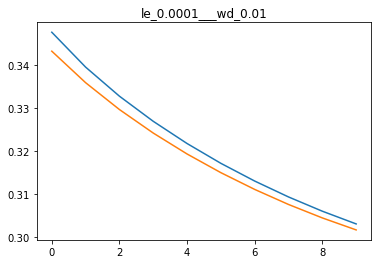

EPOCHS:  1
train loss:  tensor(0.3902, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3809, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3725, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3641, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3566, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3492, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3429, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3367, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3315, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3263, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3219, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3176, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3140, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3105, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.3074, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3044, device='cuda:0')
EPOCHS:  9
train

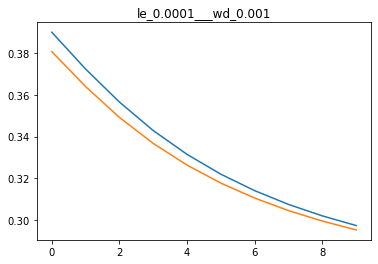

EPOCHS:  1
train loss:  tensor(0.5393, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5321, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.5244, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5158, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.5066, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4969, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.4878, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4785, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.4703, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4622, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.4551, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4482, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.4422, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4364, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.4313, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4263, device='cuda:0')
EPOCHS:  9
train

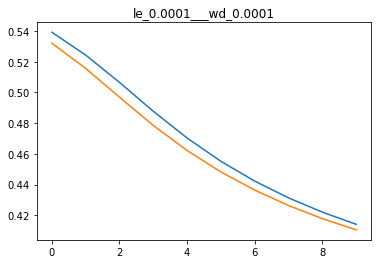

EPOCHS:  1
train loss:  tensor(0.3684, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3603, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3533, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3464, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3404, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3344, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3292, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3241, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3197, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3153, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3115, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3079, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3047, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3016, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2990, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2964, device='cuda:0')
EPOCHS:  9
train

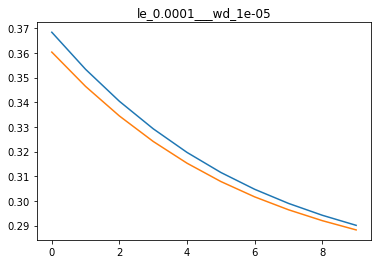

EPOCHS:  1
train loss:  tensor(0.4077, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4010, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3952, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3893, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3841, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3788, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3739, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3689, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3644, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3598, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3556, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3514, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3477, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3440, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.3408, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3375, device='cuda:0')
EPOCHS:  9
train

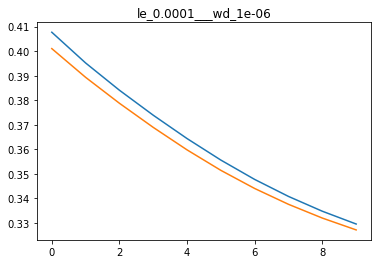

EPOCHS:  1
train loss:  tensor(0.5172, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5166, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.5160, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5155, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.5150, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5145, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.5140, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5136, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.5132, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5128, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.5125, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5121, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.5118, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5115, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.5112, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5109, device='cuda:0')
EPOCHS:  9
train

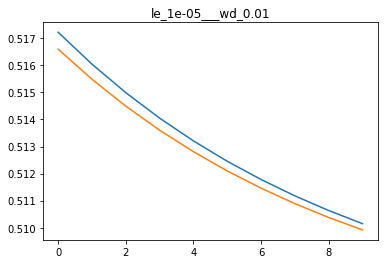

EPOCHS:  1
train loss:  tensor(0.5589, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5579, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.5570, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5561, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.5553, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5544, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.5537, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5530, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.5523, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5517, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.5511, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5505, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.5500, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5494, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.5490, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.5485, device='cuda:0')
EPOCHS:  9
train

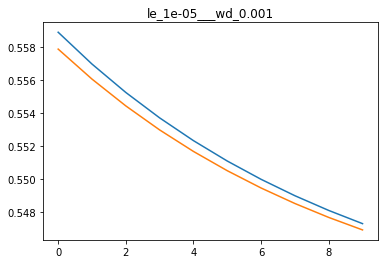

EPOCHS:  1
train loss:  tensor(0.3941, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3936, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3932, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3927, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3923, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3919, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3915, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3912, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3908, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3905, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3902, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3899, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3896, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3893, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.3891, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3888, device='cuda:0')
EPOCHS:  9
train

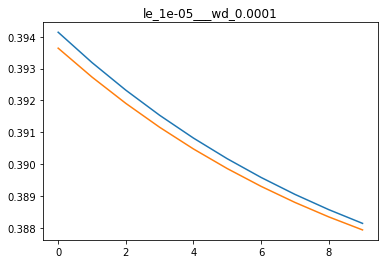

EPOCHS:  1
train loss:  tensor(0.3930, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3924, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3919, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3913, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3909, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3904, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3900, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3896, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3892, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3888, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3885, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3881, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3878, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3875, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.3873, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3870, device='cuda:0')
EPOCHS:  9
train

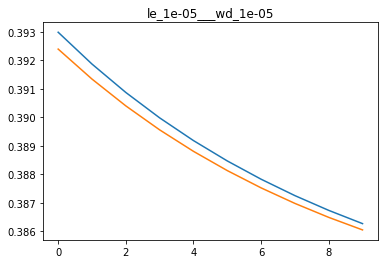

EPOCHS:  1
train loss:  tensor(0.3541, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3537, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3533, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3529, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3526, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3522, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3516, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3513, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3510, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3508, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3505, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3503, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3500, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.3498, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3496, device='cuda:0')
EPOCHS:  9
train

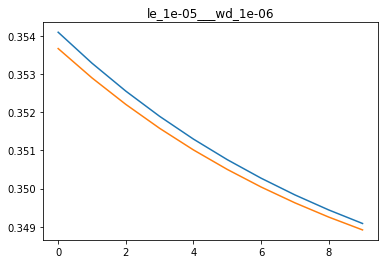

EPOCHS:  1
train loss:  tensor(0.4156, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4155, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.4155, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4154, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.4154, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4153, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.4153, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4153, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.4152, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4152, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.4152, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4151, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.4151, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4151, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.4150, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4150, device='cuda:0')
EPOCHS:  9
train

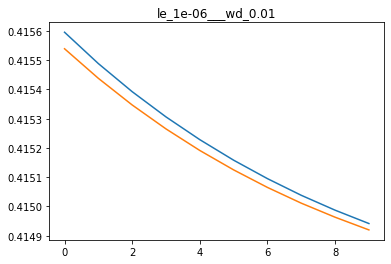

EPOCHS:  1
train loss:  tensor(0.4891, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4890, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.4889, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4888, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.4887, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4886, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.4885, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4885, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.4884, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4883, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.4882, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4882, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.4881, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4880, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.4880, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4879, device='cuda:0')
EPOCHS:  9
train

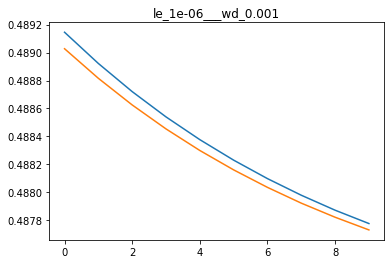

EPOCHS:  1
train loss:  tensor(0.3924, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3923, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.3923, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3922, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.3921, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3920, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.3920, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3919, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.3918, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3918, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.3917, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3916, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.3916, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3915, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.3915, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.3915, device='cuda:0')
EPOCHS:  9
train

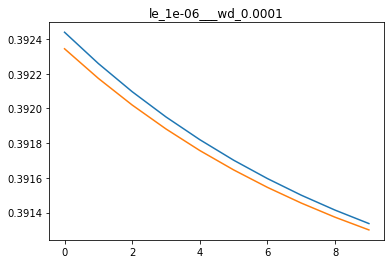

EPOCHS:  1
train loss:  tensor(0.4832, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4831, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.4831, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4830, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.4829, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4828, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.4828, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4827, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.4827, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4826, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.4825, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4825, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.4824, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4824, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.4824, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4823, device='cuda:0')
EPOCHS:  9
train

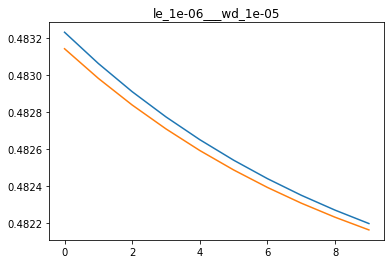

EPOCHS:  1
train loss:  tensor(0.4145, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4144, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.4144, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4144, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.4143, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4143, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.4143, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4143, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.4142, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4142, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.4142, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4142, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.4142, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4142, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.4141, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.4141, device='cuda:0')
EPOCHS:  9
train

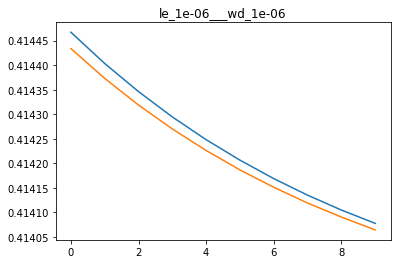

In [85]:
#model = model()
#model = rnn_model()

for lr in [1e-2,1e-3,1e-4,1e-5,1e-6]:
    for wd in [1e-2,1e-3,1e-4,1e-5,1e-6]:
        
        del model

        model = rnn_deep_many_to_many(
                    input_sequence_len  = 10,
                    input_features      =  1,
                    output_sequence_len = 10,
                    output_features     =  1,
                    hidden_layers       = 2,
                    activation_function = 'sigmoid',
                ).to(device)

        #lr  = 1e-4
        #wd  = 1e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) 
        step_size = 1
        gamma = 0.90
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        losses = train(model.to(device), epochs=10)
        
        train_loss = [float(x) for x in losses[0]]
        val_loss   = [float(x) for x in losses[1]]
        plt.title("le_{0}___wd_{1}".format(lr,wd))
        plt.plot(train_loss)
        plt.plot(val_loss)
        
        plt.show()

EPOCHS:  1
train loss:  tensor(0.3819, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2993, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.2717, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2568, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.2518, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2484, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.2467, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2454, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.2447, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2441, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.2438, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2435, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.2434, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2432, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.2431, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2431, device='cuda:0')
EPOCHS:  9
train

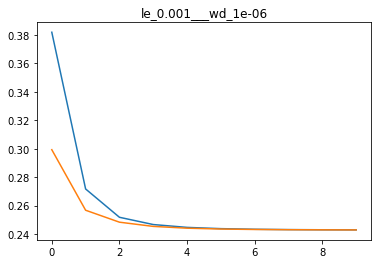

In [90]:
del model

model = rnn_deep_many_to_many(
            input_sequence_len  = 10,
            input_features      =  1,
            output_sequence_len = 10,
            output_features     =  1,
            hidden_layers       = 2,
            activation_function = 'sigmoid',
        ).to(device)

lr  = 0.001
wd  = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) 
step_size = 1
gamma = 0.90
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
losses = train(model.to(device), epochs=10)

train_loss = [float(x) for x in losses[0]]
val_loss   = [float(x) for x in losses[1]]
plt.title("le_{0}___wd_{1}".format(lr,wd))
plt.plot(train_loss)
plt.plot(val_loss)

plt.show()

In [91]:
#model_ =  nn.RNN(5,1,2, batch_first=True).to(device)
params = {
    'batch_size' : 32,
    'shuffle'    : False,
    'num_workers': 2
}

training_set         = Dataset( train_ids, data )
training_generator   = torch.utils.data.DataLoader( training_set, **params, pin_memory=True ) 
validation_set       = Dataset( test_ids, data )
validation_generator = torch.utils.data.DataLoader( validation_set, **params, pin_memory=True )

real = np.zeros(len(train_ids))
output = np.zeros(len(train_ids))
j = 0
for i,batch in enumerate(training_generator):
    real[j:j+batch[0].shape[0]] = batch[1][:,9]
    #output[j:j+batch[0].shape[0]] = model(batch[0].to(device)).cpu().detach().numpy()
    #print(model(batch[0].unsqueeze(2).to(device))[:,9].squeeze(1).shape)
    output[j:j+batch[0].shape[0]] = model(batch[0].unsqueeze(2).to(device))[:,9].squeeze(1).cpu().detach().numpy()
    j += batch[0].shape[0]

# j = 0
# for i,batch in enumerate(training_generator):
#     real[j:j+batch[0].shape[0]] = batch[1]
#     #output[j:j+batch[0].shape[0]] = model(batch[0].to(device)).cpu().detach().numpy()
#     output[j:j+batch[0].shape[0]] = model(batch[0].unsqueeze(1).to(device))[0][:,0,0].cpu().detach().numpy()
#     j += batch[0].shape[0]

(0.0, 1000.0)

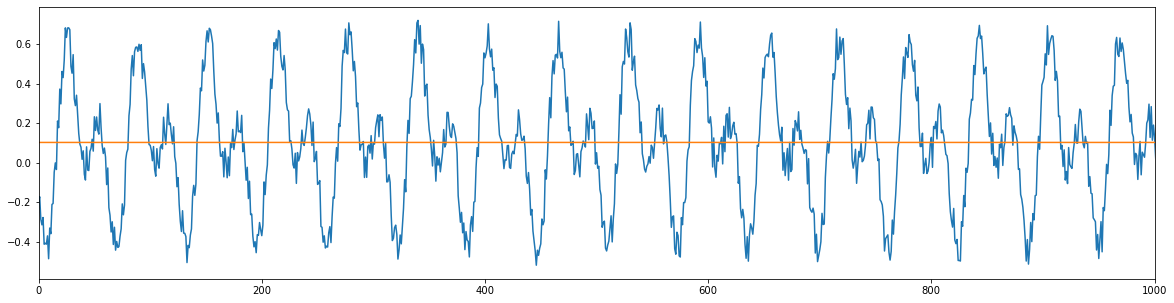

In [92]:
plt.figure(figsize=(20,5))
plt.plot(real)
plt.plot(output)
plt.xlim(0,1000)

In [62]:
input_ = batch[0].to(device)
output = model(batch[0].unsqueeze(2).to(device))

In [69]:
output[0].squeeze(1).shape

torch.Size([10])

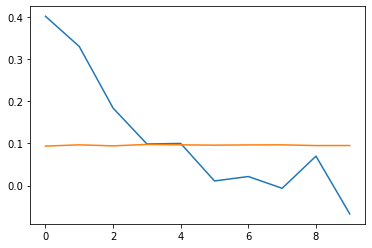

In [71]:
plt.plot(input_[0].cpu())
plt.plot(output[0].squeeze(1).cpu().detach().numpy() )

In [37]:
model(batch[0].unsqueeze(2).to(device)).shape

torch.Size([32, 10, 1])

In [45]:
batch[1].unsqueeze(2).shape

torch.Size([32, 10, 1])

In [93]:
# new model

In [159]:
class rnn_model(nn.Module):
    def __init__(
            self,
            dropout: float = 0.2,
    ) -> None:
        super(rnn_model, self).__init__()
        self.rnn1 = nn.RNN(1,20,2, batch_first=True)
        self.rnn2 = nn.RNN(20,20,2, batch_first=True)
        self.rnn3 = nn.RNN(20,1,2, batch_first=True)
    
    def forward(self, x):
        x,h = self.rnn1(x)
        x,h = self.rnn2(x)
        x,h = self.rnn3(x)
        return x,h

# class rnn_model(nn.Module):
#     def __init__(
#             self,
#             dropout: float = 0.2,
#     ) -> None:
#         super(rnn_model, self).__init__()
#         self.rnn1 = nn.RNN(5,20,2, batch_first=True)
#         self.rnn2 = nn.RNN(20,20,2, batch_first=True)
#         self.rnn3 = nn.RNN(20,1,2, batch_first=True)
    
#     def forward(self, x):
#         x,h = self.rnn1(x)
#         x,h = self.rnn2(x)
#         x,h = self.rnn3(x)
#         return x,h

In [160]:
model = rnn_model()

In [141]:
input_ = torch.randn(32,10,1)

In [142]:
model(input_)[0].shape

torch.Size([32, 10, 1])

In [144]:
batch[1].unsqueeze(2).shape

torch.Size([32, 10, 1])

In [101]:
for batch in training_generator:
    break
    
batch[0].shape

torch.Size([32, 10])

In [146]:
def train_one_epoch(model, loss_fn):
    model.train()
    running_loss = 0.
    for i,batch in enumerate(training_generator):
        X = batch[0].unsqueeze(2).to(device)
        Y = batch[1].unsqueeze(2).to(device)
        optimizer.zero_grad()
        output  = model(X)[0]
        loss    = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        running_loss += loss
    return running_loss/(i+1)

def val_one_epoch(model, loss_fn):
    model.eval()
    running_loss = 0.
    for i,batch in enumerate(training_generator):
        X = batch[0].unsqueeze(2).to(device)
        Y = batch[1].unsqueeze(2).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output  = model(X)[0]
        loss    = loss_fn(output, Y)
        running_loss += loss
    return running_loss/(i+1)

def train(model, epochs=10):
    loss_fn = torch.nn.L1Loss()
    train_loss = []
    val_loss   = []
    
    for epoch in range(epochs):
        model.train(True)
        print("EPOCHS: ", epoch + 1)
        loss = train_one_epoch(model, loss_fn=loss_fn)
        print("train loss: ",loss)
        train_loss.append(loss)
        model.train(False)
        loss = val_one_epoch(model, loss_fn=loss_fn)
        val_loss.append(loss)
        print("val loss: ",loss)
        scheduler.step()
    return [train_loss, val_loss]

EPOCHS:  1
train loss:  tensor(0.2244, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.2081, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.1982, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1906, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.1835, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1748, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.1705, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1668, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.1633, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1613, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.1586, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1555, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.1532, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1498, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.1475, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1449, device='cuda:0')
EPOCHS:  9
train

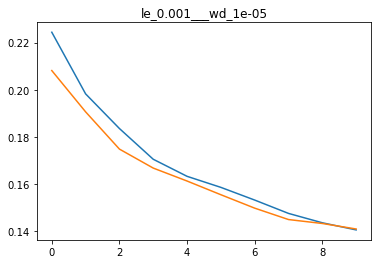

In [161]:
lr  = 0.001
wd  = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) 
step_size = 1
gamma = 0.90
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
losses = train(model.to(device), epochs=10)

train_loss = [float(x) for x in losses[0]]
val_loss   = [float(x) for x in losses[1]]
plt.title("le_{0}___wd_{1}".format(lr,wd))
plt.plot(train_loss)
plt.plot(val_loss)

plt.show()

In [162]:
#model_ =  nn.RNN(5,1,2, batch_first=True).to(device)
params = {
    'batch_size' : 32,
    'shuffle'    : False,
    'num_workers': 2
}

training_set         = Dataset( train_ids, data )
training_generator   = torch.utils.data.DataLoader( training_set, **params, pin_memory=True ) 
validation_set       = Dataset( test_ids, data )
validation_generator = torch.utils.data.DataLoader( validation_set, **params, pin_memory=True )

real = np.zeros(len(train_ids))
output = np.zeros(len(train_ids))
j = 0
for i,batch in enumerate(training_generator):
    real[j:j+batch[0].shape[0]] = batch[1][:,9]
    #output[j:j+batch[0].shape[0]] = model(batch[0].to(device)).cpu().detach().numpy()
    #print(model(batch[0].unsqueeze(2).to(device))[:,9].squeeze(1).shape)
    output[j:j+batch[0].shape[0]] = model(batch[0].unsqueeze(2).to(device))[0].squeeze(2)[:,9].cpu().detach().numpy()
    j += batch[0].shape[0]



(0.0, 1000.0)

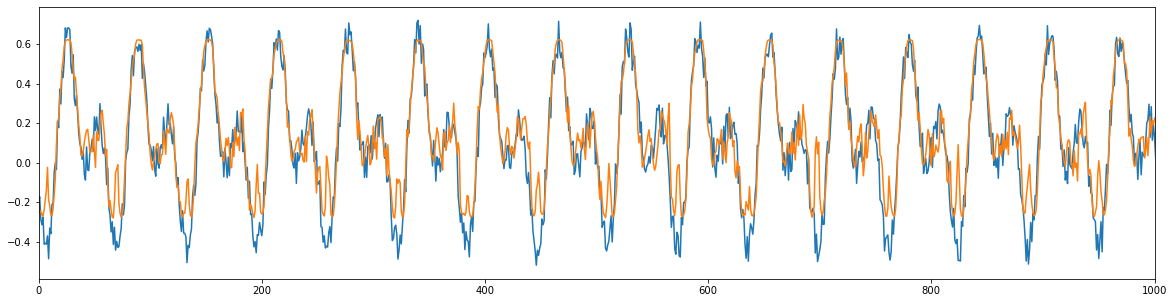

In [163]:
plt.figure(figsize=(20,5))
plt.plot(real)
plt.plot(output)
plt.xlim(0,1000)